<a href="https://colab.research.google.com/github/IshaKumari22/Customer-segmentation-rfm/blob/main/Customer_Segmentation_using_RFM_Analysis_%2B_KMeans_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 .Import Required Libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

2.Load the Dataset

In [34]:
df=pd.read_csv('online_retail_II.csv',encoding='ISO-8859-1')
print(df.head())
print(df.columns)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


3.Clean the data

In [35]:
#Strip whitespace from column names
df.columns=df.columns.str.strip()

#Drop rows with missing Customer ID
df=df.dropna(subset=['Customer ID'])

#Create TotalPrice=Quantity * Price
df['TotalPrice']=df['Quantity']*df['Price']

#Convert InvoiceDate to datetime
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

#Preview cleaned data
df.head()

/tmp/ipython-input-35-429510387.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice']=df['Quantity']*df['Price']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


4.RFM Feature Engineering

In [40]:
#Step 1:Set snapshot date(1 day after the last invoice)
snapshot_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)

#Step 2:Group by Customer ID and calculate RFM
rfm=df.groupby('Customer ID').agg({
    'InvoiceDate':lambda x:(snapshot_date-x.max()).days,       #Recency
    'Invoice':'nunique'  ,                                      #Frequency
    'TotalPrice' : 'sum'                                        #Monetary
})
#Step 3:Rename columns
rfm.columns=['Recency','Frequency','Monetary']

#Step 4:Remove customers with zero or negative spend
rfm=rfm[rfm['Monetary']>0]

#Step 5:Reset index to bring Customer ID as column
rfm.reset_index(inplace=True)

#View result
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12347.0,2,8,5633.32
1,12348.0,75,5,2019.40
2,12349.0,19,5,4404.54
3,12350.0,310,1,334.40
4,12351.0,375,1,300.93


5.Normalize (Scale) RFM Features

In [45]:
from sklearn.preprocessing import StandardScaler

#Keep a copy of original RFM(for reference or plotting later)
rfm_original=rfm.copy()

#Select only the RFM columns
rfm_features=rfm[['Recency','Frequency','Monetary']]

#Scale using StandardScaler (mean=0 ,std=1)
scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_features)

6.Apply KMeans Clustering

In [47]:
from sklearn.cluster import KMeans

#Apply KMeans with 4 clusters
kmeans=KMeans(n_clusters=4,random_state=42)
rfm['cluster']=kmeans.fit_predict(rfm_scaled)

#View sample output
rfm.head()



,Customer ID,Recency,Frequency,Monetary,cluster
0,12347.0,2,8,5633.32,1
1,12348.0,75,5,2019.40,1
2,12349.0,19,5,4404.54,1
3,12350.0,310,1,334.40,0
4,12351.0,375,1,300.93,0


7.Analyze and Understand the Clusters

In [48]:
#Analyze average RFM values for each cluster
rfm.groupby('cluster').mean(numeric_only=True).round(1)

,Customer ID,Recency,Frequency,Monetary
cluster,,,,
0,15352.0,458.9,2.6,698.2
1,15301.8,64.7,9.2,3039.6
2,15101.3,19.8,178.1,115760.2
3,16374.0,1.5,158.5,560778.6


8.Visualize the Clusters

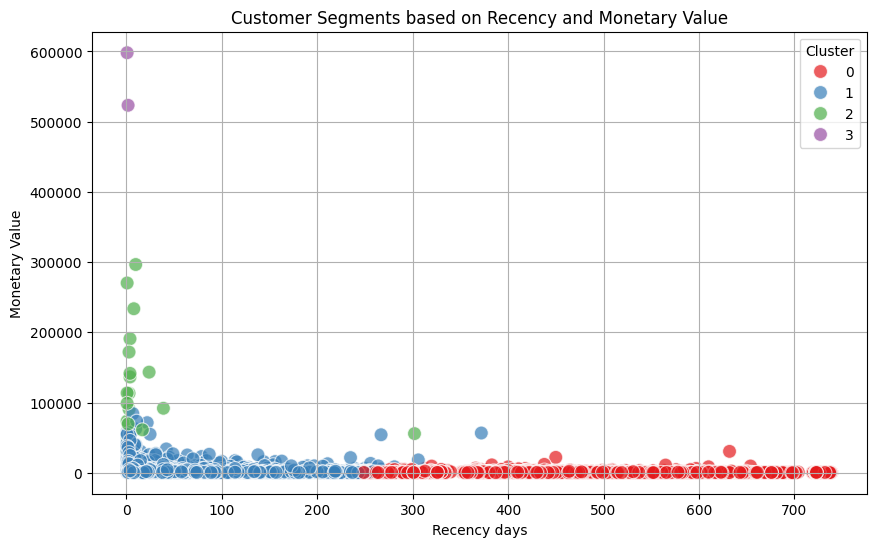

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot clusters using Recency and Monetary
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='cluster',
    palette='Set1',
    s=100,
    alpha=0.7
)
plt.title('Customer Segments based on Recency and Monetary Value')
plt.xlabel('Recency days')
plt.ylabel('Monetary Value')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [53]:
rfm

,Customer ID,Recency,Frequency,Monetary,cluster
0,12347.0,2,8,5633.32,1
1,12348.0,75,5,2019.40,1
2,12349.0,19,5,4404.54,1
3,12350.0,310,1,334.40,0
4,12351.0,375,1,300.93,0
...,...,...,...,...,...
5837,18283.0,4,22,2736.65,1
5838,18284.0,430,2,436.68,0
5839,18285.0,661,1,427.00,0
5840,18286.0,477,3,1188.43,0


In [55]:
rfm.to_csv("rfm_clusters.csv",index=False)

In [56]:
from google.colab import files
files.download("rfm_clusters.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>